<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Predicting Shots Made Per Game by Kobe Bryant

_Authors: Kiefer Katovich (SF)_

---

In this lab you'll be using regularized regression penalties — ridge, lasso, and elastic net — to try and predict how many shots Kobe Bryant made per game during his career.

The Kobe Shots data set contains hundreds of columns representing different characteristics of each basketball game. Fitting an ordinary linear regression using every predictor would dramatically overfit the model, considering the limited number of observations (games) we have available. Plus, many of the predictors have significant multicollinearity. 


**Warning:** Some of these calculations are computationally expensive and may take a while to execute. It may be worthwhile to only use a portion of the data to perform these calculations, especially if you've experienced kernel issues in the past.

---

### 1) Load packages and data.

In [11]:
import numpy as np
import pandas as pd
import patsy

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFECV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [135]:
kobe = pd.read_csv('./datasets/kobe_superwide_games.csv')
kobe.head()

,SHOTS_MADE,AWAY_GAME,SEASON_OPPONENT:atl:1996-97,SEASON_OPPONENT:atl:1997-98,SEASON_OPPONENT:atl:1999-00,SEASON_OPPONENT:atl:2000-01,SEASON_OPPONENT:atl:2001-02,SEASON_OPPONENT:atl:2002-03,SEASON_OPPONENT:atl:2003-04,SEASON_OPPONENT:atl:2004-05,...,ACTION_TYPE:tip_layup_shot,ACTION_TYPE:tip_shot,ACTION_TYPE:turnaround_bank_shot,ACTION_TYPE:turnaround_fadeaway_bank_jump_shot,ACTION_TYPE:turnaround_fadeaway_shot,ACTION_TYPE:turnaround_finger_roll_shot,ACTION_TYPE:turnaround_hook_shot,ACTION_TYPE:turnaround_jump_shot,SEASON_GAME_NUMBER,CAREER_GAME_NUMBER
0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2
2,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
3,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4
4,0.0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5


---

### 2) Examine the data.

- How many columns are there?
- Examine what the observations (rows) and columns represent.
- Why might regularization be particularly useful for modeling this data?

In [21]:
# A:
kobe.info()

# Too many cols (645 cols), need to prioritize certain more important features, hence need regularization. 
# Regularization would be good here because there are so many columns (feature selection can be done) and 
# many of the columns represent similar things (there is multicollinearity).

# Cols represent his game statistics. Rows represent each game he played.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558 entries, 0 to 1557
Columns: 645 entries, SHOTS_MADE to CAREER_GAME_NUMBER
dtypes: float64(640), int64(5)
memory usage: 7.7 MB


---

### 3) Create predictor and target variables. Standardize the predictors.

Why is normalization necessary for regularized regressions?

Use the `sklearn.preprocessing` class `StandardScaler` to standardize the predictors.

In [10]:
# A:
kobe.describe()

,SHOTS_MADE,AWAY_GAME,SEASON_OPPONENT:atl:1996-97,SEASON_OPPONENT:atl:1997-98,SEASON_OPPONENT:atl:1999-00,SEASON_OPPONENT:atl:2000-01,SEASON_OPPONENT:atl:2001-02,SEASON_OPPONENT:atl:2002-03,SEASON_OPPONENT:atl:2003-04,SEASON_OPPONENT:atl:2004-05,...,ACTION_TYPE:tip_layup_shot,ACTION_TYPE:tip_shot,ACTION_TYPE:turnaround_bank_shot,ACTION_TYPE:turnaround_fadeaway_bank_jump_shot,ACTION_TYPE:turnaround_fadeaway_shot,ACTION_TYPE:turnaround_finger_roll_shot,ACTION_TYPE:turnaround_hook_shot,ACTION_TYPE:turnaround_jump_shot,SEASON_GAME_NUMBER,CAREER_GAME_NUMBER
count,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,...,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000,1558.000000
mean,7.358793,0.500642,0.001284,0.001284,0.000642,0.000642,0.001284,0.001284,0.000642,0.000642,...,0.000064,0.006207,0.002047,0.000032,0.014149,0.000050,0.000433,0.031766,42.946727,780.486521
std,3.471180,0.500160,0.035817,0.035817,0.025335,0.025335,0.035817,0.035817,0.025335,0.025335,...,0.001791,0.022033,0.011133,0.001267,0.041313,0.001390,0.004902,0.049402,26.048206,449.923227
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,391.250000
50%,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,780.500000
75%,10.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,63.000000,1169.750000
max,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.050000,0.250000,0.133333,0.050000,0.533333,0.041667,0.111111,0.352941,105.000000,1559.000000


In [158]:
features = [k for k in kobe.columns if k!='SHOTS_MADE']
X = kobe[features]
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Some features have min-max ranges that are too wide relative to other features. 
# eg. ACTION_TYPE:turnaround_jump_shot (0 to 0.35), but CAREER_GAME_NUMBER (1 to 1559).
# Hence need normalization to scale all predictors to a similar range, else regularization would wrongly
# penalize predictors which are smaller by giving them smaller coefficients.

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


---

### 4. Build a linear regression predicting `SHOTS_MADE` from the rest of the columns.

Cross-validate the $R^2$ of an ordinary linear regression model with 10 cross-validation folds.

How does it perform?

In [144]:
# A:
Y = kobe['SHOTS_MADE'].values
lm = LinearRegression()
cross_val_score(lm, X, Y, cv=10).mean()

# The mean R2 value is so hugely -ve relative to the baseline SSR (which compares to the mean of the target), 
# it is clearly wrong and it is likely overfitting. 
# Here we have chosen ALL the possible predictors to predict the target, 
# which shouldn't be the way (due to multicollinearity between some predictors).
# As we'll see below, Ridge/Lasso will reduce the importance/coeff of extraneous predictors...

-2.4148263774796837e+28

---

### 5) Find an optimal value for the ridge regression alpha using `RidgeCV`.

Go to the documentation and [read how RidgeCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).

> *Hint: Once the RidgeCV is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that ridge performs best when searching alphas through logarithmic space (`np.logspace`). This may take awhile to fit.


In [145]:
# A:
# create RidgeCV model
ridge_cv = RidgeCV

# create range of alphas
ridge_alphas = np.logspace(0,5,200)

# fit Ridgecv model
ridge_model = ridge_cv(alphas=ridge_alphas,cv=5).fit(X,Y)

# find optimum alpha
ridge_alpha_optimal = ridge_model.alpha_
print('Optimal alpha = ',ridge_alpha_optimal)

Optimal alpha =  580.5225516094902


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


---

### 6) Cross-validate the ridge regression $R^2$ with the optimal alpha.

Is it better than the linear regression? If so, why might this be?

In [146]:
# A:
# set alpha in Ridge 
ridge_model = Ridge(alpha=ridge_alpha_optimal)

# get mean cross val score of R2
cross_val_score(ridge_model,X,Y,cv=5).mean()

# significantly better, more sensible looking R2 (0.55). 
# This is because ridge has reduced the coef of all extraneous predictors, to reduce drastic overfitting

0.55050553220233

---

### 7) Find an optimal value for lasso regression alpha using `LassoCV`.

Go to the documentation and [read how LassoCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). It is very similar to `RidgeCV`.

> *Hint: Again, once the `LassoCV` is fit, the attribute `.alpha_` contains the best alpha parameter it found through cross-validation.*

Recall that lasso, unlike ridge, performs best when searching for alpha through linear space (`np.linspace`). However, you can actually let the LassoCV decide what alphas to use itself by setting the keyword argument `n_alphas=` to however many alphas you want it to search over. We recommend letting scikit-learn choose the range of alphas.

_**Tip:** If you find your CV taking a long time and you're not sure if it's working, set `verbose =1`._

In [147]:
# A:
# create LassoCV model
lasso_cv = LassoCV

## create range of alphas, then fit lasso model
# lasso_alphas = np.linspace(0,0.5,200)
# lasso_model = lasso_cv(alphas=lasso_alphas, cv=5).fit(X,Y)

# alternatively, just let Lasso decide to search through how many alphas itself, then fit LassoCV model
lasso_model = lasso_cv(n_alphas=100, cv=5).fit(X,Y)

# find optimum alpha
lasso_alpha_optimal = lasso_model.alpha_
print('Optimal alpha = ',lasso_alpha_optimal)

Optimal alpha =  0.05654731553065333


---

### 8) Cross-validate the lasso $R^2$ with the optimal alpha.

Is it better than the linear regression? Is it better than ridge? What do the differences in results imply about the issues with the data set?

In [201]:
# A:
# set alpha in Lasso
lasso_model = Lasso(alpha=lasso_alpha_optimal)

# get mean cross val score of R2
cross_val_score(lasso_model,X,Y,cv=5).mean()

# also significantly better, more sensible looking R2 (0.57). Slightly better then Ridge
# This is because lasso has reduced the coef of all extraneous predictors, to reduce drastic overfitting, 
# AND it is also stricter than ridge by even zeroing-out these extraneous predictors.  

0.5726505665056653

---

### 9) Look at the coefficients for variables in the lasso.

1. Show the coefficient for variables, ordered from largest to smallest coefficient by absolute value.
2. What percent of the variables in the original data set are "zeroed-out" by the lasso?
3. What are the most important predictors for how many shots Kobe made in a game?

> **Note:** If you only fit the lasso within `cross_val_score`, you'll have to refit it outside of that function to pull out the coefficients.

In [182]:
# A:
# pack column names and coefficients into a dataframe
lasso_coef = pd.DataFrame({'predictor':kobe.columns[1:]})
lasso_coef['coef'] = pd.DataFrame(lasso_model.fit(X,Y).coef_)

lasso_coef.sort_values(by='coef',ascending=False).head(20)

# 3 most important predictors would be: no. of jump shots, no. of 2pt field shots, no. of shots in the restricted area

,predictor,coef
579,COMBINED_SHOT_TYPE:jump_shot,1.267017
574,SHOT_TYPE:2pt_field_goal,0.828362
566,SHOT_ZONE_BASIC:restricted_area,0.469498
577,COMBINED_SHOT_TYPE:dunk,0.278567
423,SEASON_OPPONENT:sac:1999-00,0.140978
575,SHOT_TYPE:3pt_field_goal,0.140398
233,SEASON_OPPONENT:mem:2009-10,0.128086
333,SEASON_OPPONENT:nyk:2008-09,0.120480
582,SECONDS_REMAINING,0.120324
561,SHOT_ZONE_BASIC:above_the_break_3,0.118493


In [187]:
(lasso_coef['coef']==0).sum()/len(lasso_coef['coef'])

# 73% of the coefficients were zeroed-out

0.7360248447204969

---

### 10) Find an optimal value for elastic net regression alpha using `ElasticNetCV`.

Go to the documentation and [read how ElasticNetCV works](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html).

Note that here you'll be optimizing both the alpha parameter and the l1_ratio:
- `alpha`: Strength of regularization.
- `l1_ratio`: Amount of ridge vs. lasso (0 = all ridge, 1 = all lasso).
    
Do not include 0 in the search for `l1_ratio` — it won't allow it and will break.

You can use `n_alphas` for the alpha parameters instead of setting your own values, which we highly recommend.

Also, be careful setting too many l1_ratios over cross-validation folds in your search. It can take a long time if you choose too many combinations and, for the most part, there are diminishing returns in this data.

In [202]:
# A:
# create ElasticNetCV model
elasticnet_cv = ElasticNetCV

# create list of L1 ratios
l1_ratio_list = np.linspace(0.1,1,20)

# set no. of alphas to search over, then fit ElasticNetCV model
elasticnet_model = elasticnet_cv(l1_ratio=l1_ratio_list, n_alphas=100, cv=5).fit(X,Y)

# find optimum l1 ratio, alpha
elasticnet_l1ratio_optimal = elasticnet_model.l1_ratio_
print('Optimal L1 ratio = ',elasticnet_l1ratio_optimal)
elasticnet_alpha_optimal = elasticnet_model.alpha_
print('Optimal alpha = ',elasticnet_alpha_optimal)

Optimal L1 ratio =  0.9526315789473684
Optimal alpha =  0.05935906050179077


---

### 11) Cross-validate the elastic net $R^2$ with the optimal alpha and l1_ratio.

How does it compare to the ridge and lasso regularized regressions?

In [203]:
# A:
# set alpha in elasticnet
elasticnet_model = ElasticNet(alpha=elasticnet_alpha_optimal)

# get mean cross val score of R2
cross_val_score(elasticnet_model,X,Y,cv=5).mean()

# also significantly better than baseline, more sensible looking R2 (0.56). 
# Slightly better than Ridge (was 0.55), slightly worse than Lasso (was 0.57)
# This is because it is a compromise between Ridge and Lasso

0.5647835784281359

---

### 12. [Bonus] Compare the residuals for ridge and lasso visually.


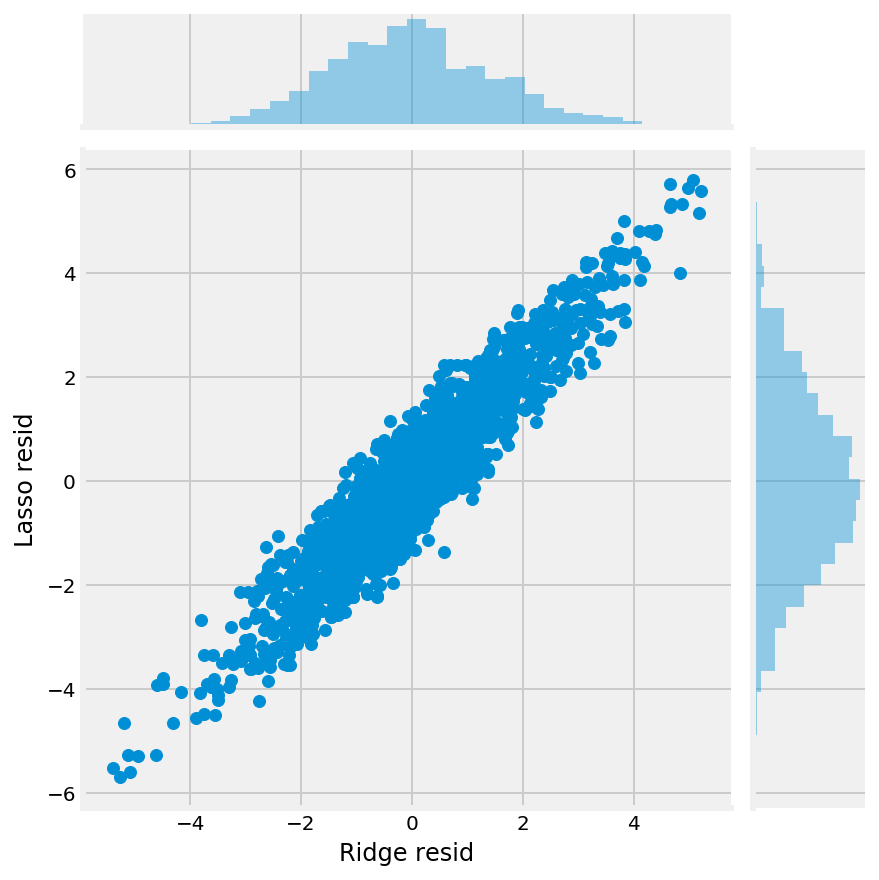

In [221]:
# A: Maybe a jointplot?
# get prediction values
y_hat_ridge = ridge_model.fit(X,Y).predict(X)
y_hat_lasso = lasso_model.fit(X,Y).predict(X)

# get residuals
y_hat_ridge_resid = y-y_hat_ridge
y_hat_lasso_resid = y-y_hat_lasso

# plot jointplot
sns.jointplot(x=y_hat_ridge_resid,y=y_hat_lasso_resid).set_axis_labels("Ridge resid", "Lasso resid");
